# 1 - Imports

In [43]:
import sys
sys.path.append('/home/usuaris/veu/federico.costa/git_repositories/DoubleAttentionSpeakerVerification/scripts/')

import argparse
import librosa
import librosa.display as ld
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from feature_extractor import FeatureExtractor
from settings import FEATURE_EXTRACTOR_DEFAULT_SETTINGS

# 2 - Feature extractor class

In [67]:
default_params_dict = FEATURE_EXTRACTOR_DEFAULT_SETTINGS

default_params_dict['audio_paths_file_folder'] = '/home/usuaris/veu/federico.costa/git_repositories/DoubleAttentionSpeakerVerification/feature_extractor/'
default_params_dict['n_mels'] = 80

default_params = argparse.Namespace(**default_params_dict)

feature_extractor = FeatureExtractor(default_params)

# 3 - Tests

In [68]:
feature_extractor.count_input_lines()

with open(feature_extractor.params.audio_paths_file_path, 'r') as file:
    
    for line in file:

        audio_path = line.replace("\n", "")

        print(f"[Feature Extractor] Processing file {audio_path}...")

        file_dump_path = '.'.join(line.split(".")[:-1]) # remove the file extension
        file_dump_path = file_dump_path + ".pickle" # add the pickle extension

        if (feature_extractor.params.overwrite == True) or (feature_extractor.params.overwrite == False and not os.path.exists(file_dump_path)):
                    
            samples, sampling_rate = librosa.load(
                f'{audio_path}',
                sr = feature_extractor.params.sampling_rate,
                mono = True, # converts to mono channel
                ) 

            assert int(sampling_rate) == int(feature_extractor.params.sampling_rate)
            
            # Pre-emphasis
            samples *= 32768 # HACK why this number?
            samples[1:] = samples[1:] - feature_extractor.params.pre_emph_coef * samples[:-1]
            samples[0] *= (1 - feature_extractor.params.pre_emph_coef)

            # Short time Fourier Transform
            D = librosa.stft(
                samples, 
                n_fft = int(feature_extractor.params.n_fft_secs * sampling_rate), 
                hop_length = int(feature_extractor.params.hop_length_secs * sampling_rate),
                win_length = int(feature_extractor.params.win_length_secs * sampling_rate), 
                window = feature_extractor.params.window, 
                center = False,
                )
            
            magnitudes = np.abs(D)
            low_freq = 0
            high_freq = sampling_rate / 2

            mel_spectrogram = librosa.feature.melspectrogram(
                S = magnitudes, 
                sr = sampling_rate, 
                n_mels = feature_extractor.params.n_mels, 
                fmin = low_freq, 
                fmax = high_freq, 
                norm = None,
                )
        
            log_mel_spectrogram = np.log(np.maximum(1, mel_spectrogram))
        
        break

[Feature Extractor] Processing file /home/usuaris/veussd/DATABASES/VoxCeleb/VoxCeleb1/test/id10305/gbTZ7k9e_Z0/00006.wav...


In [71]:
log_mel_spectrogram.shape

(80, 438)

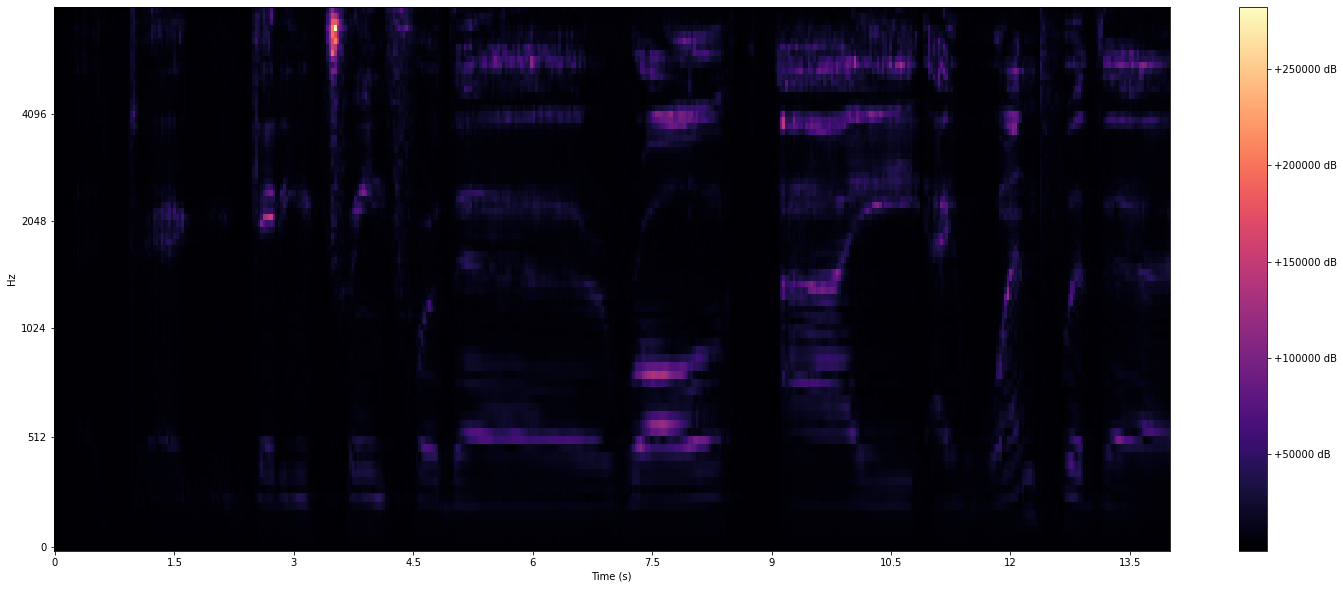

In [69]:
plt.figure(figsize=(25, 10))

librosa.display.specshow(
    mel_spectrogram, 
    x_axis = "s",
    y_axis = "mel", 
    sr = sampling_rate,
    )

plt.colorbar(format="%+2.f dB")
plt.show()

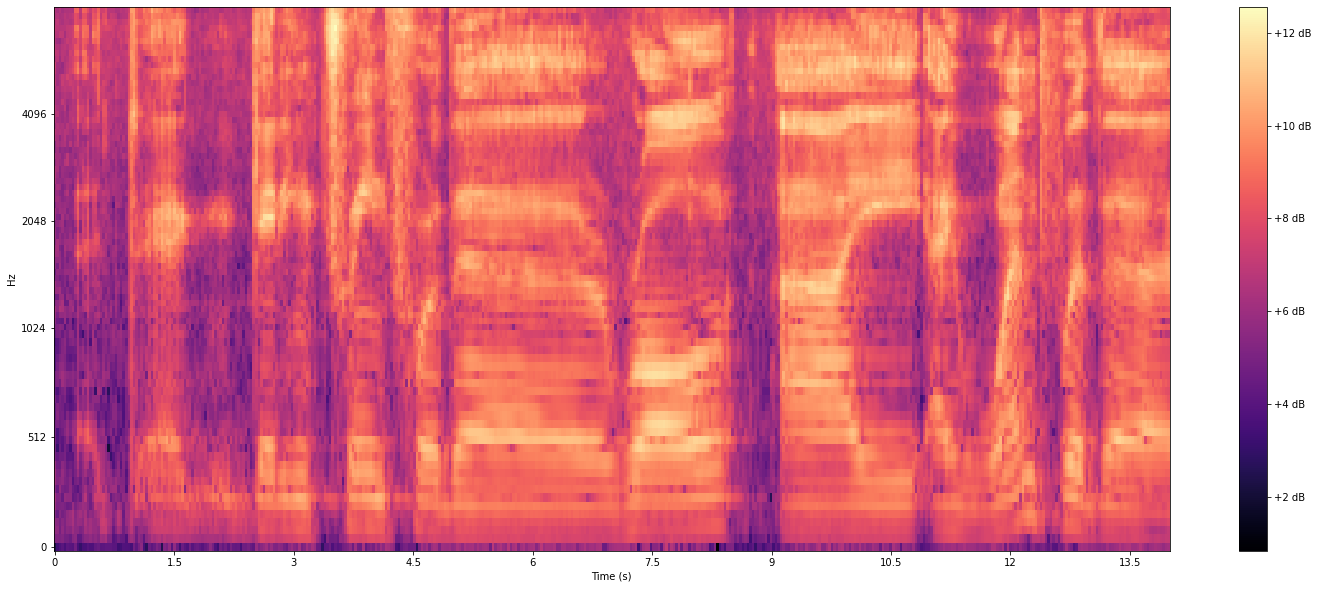

In [70]:
plt.figure(figsize=(25, 10))

librosa.display.specshow(
    log_mel_spectrogram, 
    x_axis = "s",
    y_axis = "mel", 
    sr = sampling_rate,
    )

plt.colorbar(format="%+2.f dB")
plt.show()